In [1]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

--2024-10-15 20:28:20--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 3.5.205.182, 52.95.155.44
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|3.5.205.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812068227 (774M) [application/zip]
Saving to: ‘hydranets-data-2.zip’

hydranets-data-2.zi 100%[===================>] 774.45M  15.9MB/s    in 57s     

2024-10-15 20:29:18 (13.6 MB/s) - ‘hydranets-data-2.zip’ saved [812068227/812068227]



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

In [4]:
print(len(images))
print(len(seg))
print(len(depth))

1449
1449
1449


In [5]:
CMAP = np.load("cmap_nyud.npy")
print(len(CMAP))

256


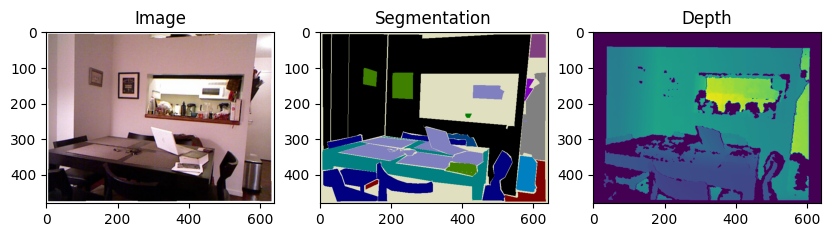

In [6]:
idx = np.random.randint(0, len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5))
ax0.imshow(Image.open(images[idx]))
ax0.set_title("Image")
ax1.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax1.set_title("Segmentation")
ax2.imshow(Image.open(depth[idx]))
ax2.set_title("Depth")
plt.show()

In [7]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   2   4   6   7  10  20  21  37  38  39 255]
13


## Dataloader

In [8]:
data_file = "train_list_depth.txt"
with open(data_file, "rb") as f:
  datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
root_dir = "/nyud"
mask_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [9]:
datalist[0]

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']

In [10]:
abs_path = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_path

['nyud/rgb/000003.png', 'nyud/masks/000003.png', 'nyud/depth/000003.png']

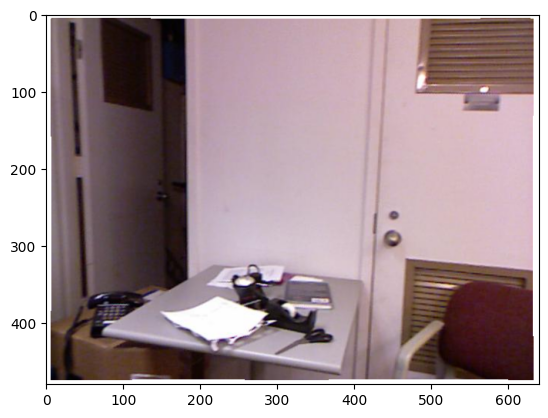

In [11]:
img_arr = np.array(Image.open(abs_path[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud/masks/000003.png


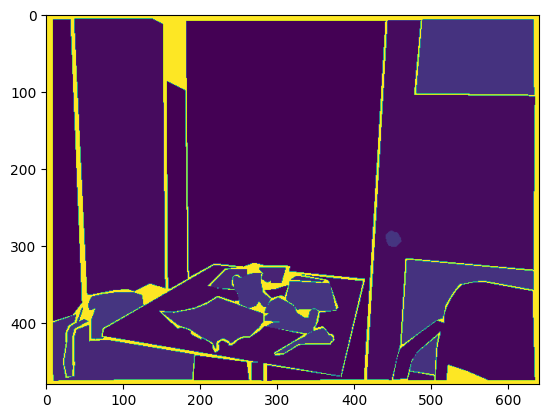

depth
nyud/depth/000003.png


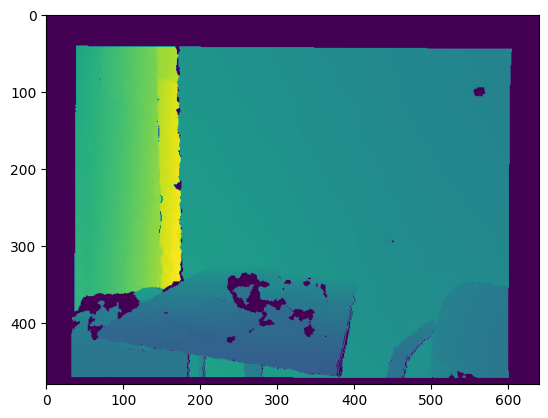

In [12]:
mask_names = ("segm", "depth")
for mask_name, mask_path in zip(mask_names, abs_path[1:]):
  print(mask_name)
  print(mask_path)
  mask = np.array(Image.open(mask_path))
  plt.imshow(mask)
  plt.show()

In [13]:
from torch.utils.data import Dataset

class HydranetDataset(Dataset):

  def __init__(self, data_file, transform=None):
    with open(data_file, "rb") as f:
      datalist = f.readlines()
    self.datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
    self.transform = transform
    self.root_dir = "nyud"
    self.mask_names = ("segm", "depth")

  def __len__(self):
    return len(self.datalist)

  def __getitem__(self, idx):
    abs_paths = [os.path.join(self.root_dir, rpath) for rpath in self.datalist[idx]]
    sample = {}
    sample["image"] = np.array(Image.open(abs_paths[0]))

    for mask_name, maks_path in zip(self.masks_names, abs_pzths[1:]):
      mask = np.array(Image.open(mask_path))
      assert len(mask.shape) == 2
      sample[mask_name] = mask

    if self.transform:
      sample["names"] = self.mask_names
      sample = self.transform(sample)
      if "names" in sample:
        del sample["names"]

    return sample

### Normalization

In [14]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [15]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale]
transform_common = [Normalise(*normalise_params), ToTensor()]

In [16]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [17]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [18]:
from torch.utils.data import DataLoader

trainloader = DataLoader(
    HydranetDataset(train_file, transform=transform_train),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

valloader = DataLoader(
    HydranetDataset(val_file, transform=transform_val),
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, bias=bias, groups=groups)

In [20]:
def conv1x1(in_channels, out_channels, stride=1, dilation=0, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=dilation, bias=bias, groups=groups)

In [21]:
def batchnorm(num_features):
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

In [22]:
def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
  if act:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels),
                         nn.ReLU6(inplace=True))
  else:
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size/2.0), groups=groups, bias=False),
                         batchnorm(out_channels))

In [23]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
    super().__init__()
    intermed_planes = in_planes * expansion_factor
    self.residual = (in_planes == out_planes) and (stride == 1)
    self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                convbnrelu(intermed_planes, out_planes, 1, act=False))
  def forward(self, x):
    if self.residual:
      return x + self.output(x)
    else:
      return self.output(x)

In [26]:
class MobileNetV2(nn.Module):
  def __init__(self, return_idx=[6]):
    super().__init__()
    self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1]
    ]

    self.in_channels = 32
    self.num_layers = len(self.mobilenet_config)
    self.layer1 = convbnrelu(3, self.in_channels, 3, stride=2)

    self.return_idx = [1, 2, 3, 4, 5, 6]

    c_layer = 2

    for t, c, n, s in self.mobilenet_config:
      layers = []
      for i in range(n):
        layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
        self.in_channels = c
      setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
      c_layer += 1
    self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx]

  def forward(self, x):
    x = self.layer1(x)
    outs = []
    outs.append(self.layer2(x))
    outs.append(self.layer3(outs[-1]))
    outs.append(self.layer4(outs[-1]))
    outs.append(self.layer5(outs[-1]))
    outs.append(self.layer6(outs[-1]))
    outs.append(self.layer7(outs[-1]))
    outs.append(self.layer8(outs[-1]))
    return[outs[idx] for idx in self.return_idx]

In [27]:
encoder = MobileNetV2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<ipython-input-27-b49259eb0f6d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))


<All keys matched successfully>